<a href="https://colab.research.google.com/github/giobritos/soul_code_projeto_final/blob/main/Uniao_Dados_SP_NY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👮🏽‍♂️👮🏽‍♀️ **Tratamento dos Data Frames de São Paulo e NY**

Link para a documentação completa do projeto: [clique aqui](https://www.notion.so/Mindful-Data-Consultoria-d495964059c34acb9c8fe3d21dbb5cf6)




## **📚 1 - Instalação e importação das bibliotecas**

In [ ]:
# Instaladores 

# Google Cloud Storage
%%capture
%pip install gcsfs

# Conector MySQL
%pip install mysql-connector-python
%pip install PyMySQL

In [ ]:
# Conexão do Storage
from google.cloud import storage
from google.colab import drive

# Importa sistema operacional
import os

# Conector do MySQL
from mysql.connector import Error
from sqlalchemy import create_engine

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# MongoClient
from pymongo import MongoClient

# setando configurações de display do pandas
pd.set_option('display.max_columns',100)

## 🔗 **2 - Conexão com o DataLake**

In [ ]:
# importar drive - Conectar a GCP ao collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuração da chave de segurança
serviceAccount = '/content/projeto-final-373521-f220a17ad573.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

# Fazer acesso ao bucket do Cloud Storage
client = storage.Client()

# Criar uma variável para receber o nome do bucket
bucket = client.get_bucket('projeto-final-agsw')

## ⚒️ **3 - Extração das bases de dados**

In [ ]:
# Criando variavel com endereço dos arquivos
path1 = 'gs://projeto-final-agsw/tratados/ny_tratado.csv'
path2 = 'gs://projeto-final-agsw/tratados/sp_tratado.csv'

In [ ]:
# Gerando Data Frames
dfny = pd.read_csv(path1)
dfsp = pd.read_csv(path2)

In [ ]:
# Fazendo Back Up dos dados
dfny = dfny.copy()
dfsp = dfsp.copy()

## 🔨**4 - Padronização dos DF's**

### **▶️ Renomeando um coluna NY**

In [ ]:
# Visualizando dados
dfny.head(1)

,cidade,tipo_crime,distrito,data_ocorrencia,periodo_ocorrencia,faixa_etaria_suspeito,cor_pele_suspeito,sexo_suspeito,faixa_etaria_vitima,cor_pele_vitima,sexo_vitima,latitude_longitude,desc_foro
0,Nova York,Homicídio Doloso,Bronx,2018-07-09 14:25:00,Tarde,25-44,Branca,Masculino,25-44,Preta,Masculino,"40.804012949,-73.878331833",Outro


In [ ]:
# Verificando nome das colunas
dfny.columns

Index(['cidade', 'tipo_crime', 'distrito', 'data_ocorrencia',
       'periodo_ocorrencia', 'faixa_etaria_suspeito', 'cor_pele_suspeito',
       'sexo_suspeito', 'faixa_etaria_vitima', 'cor_pele_vitima',
       'sexo_vitima', 'latitude_longitude', 'desc_foro'],
      dtype='object')

In [ ]:
#Renomear as colunas NY
dfny.rename(columns={'distrito': 'distrito_zona'}, inplace = True)

In [ ]:
dfny.columns

Index(['cidade', 'tipo_crime', 'distrito_zona', 'data_ocorrencia',
       'periodo_ocorrencia', 'faixa_etaria_suspeito', 'cor_pele_suspeito',
       'sexo_suspeito', 'faixa_etaria_vitima', 'cor_pele_vitima',
       'sexo_vitima', 'latitude_longitude', 'desc_foro'],
      dtype='object')


### **▶️ Renomeando colunas SP**

In [ ]:
# Visualizando dados
dfsp.head(1)

,tipo_crime,n_vitimas,datahora_fato,periodo_ocorrencia,tipo_pessoa,sexo_pessoa,dt_nasc_pessoa,idade_pessoa,faixa_etaria_pessoa,cor_pele,profissao,cidade,dp_circunscricao,tipo_local_fato,logradouro,n_logradouro,latitude_longitude,corporacao_policial,situacao_policial
0,HOMICÍDIO DOLOSO,1.0,2018-01-06 20:06:00,Noite,Vítima,Masculino,NaN,NaN,Desconhecido,Não informada,NaN,São Paulo,002 DP - Bom Retiro,Via Pública,AVENIDA PRESIDENTE CASTELO BRANCO,NaN,"-23.523712052,-46.606388286",NaN,NaN


In [ ]:
dfsp.columns

Index(['tipo_crime', 'n_vitimas', 'datahora_fato', 'periodo_ocorrencia',
       'tipo_pessoa', 'sexo_pessoa', 'dt_nasc_pessoa', 'idade_pessoa',
       'faixa_etaria_pessoa', 'cor_pele', 'profissao', 'cidade',
       'dp_circunscricao', 'tipo_local_fato', 'logradouro', 'n_logradouro',
       'latitude_longitude', 'corporacao_policial', 'situacao_policial'],
      dtype='object')

In [ ]:
#Renomear as colunas SP
dfsp.rename(columns={
    'datahora_fato': 'data_ocorrencia', 'sexo_pessoa' : 'sexo_vitima', 'faixa_etaria_pessoa': 'faixa_etaria_vitima', 
    'cor_pele' : 'cor_pele_vitima'},inplace=True)


### ▶️ **Criando coluna bairro e coluna distrito_zona em SP**

In [ ]:
#Segundo a prefeitura de SP, esse DP mudou de nome https://www.prefeitura.sp.gov.br/cidade/secretarias/direitos_humanos/mulheres/rede_de_atendimento/index.php?p=209661
#Incluindo bairro e regiao
dfsp.replace({
'001 DP - Sé':'001 DP - Liberdade;Liberdade;Centro',
'002 DP - Bom Retiro':'002 DP - Bom Retiro;Bom Retiro;Centro',
'003 DP - Campos Elíseos':'003 DP - Campos Elíseos;Santa Efigênia;Centro',
'004 DP - Consolação':'004 DP - Consolação;Consolação;Centro',
'005 DP - Aclimação':'005 DP - Aclimação;Liberdade;Centro',
'006 DP - Cambuci':'006 DP - Cambuci;Cambuci;Centro',
'007 DP - Lapa':'007 DP - Lapa;Vila Romana;Zona Oeste',
'008 DP - Brás':'008 DP - Brás;Brás;Zona Leste',
'009 DP - Carandiru':'009 DP - Carandiru;Carandiru;Zona Norte',
'010 DP - Penha de França':'010 DP - Penha de França;Penha;Zona Leste',
'011 DP - Santo Amaro':'011 DP - Santo Amaro;Santo Amaro;Zona Sul',
'012 DP - Pari':'012 DP - Pari;Brás;Centro',
'013 DP - Casa Verde':'013 DP - Casa Verde;Casa Verde;Zona Norte',
'014 DP - Pinheiros':'014 DP - Pinheiros;Pinheiros;Zona Oeste',
'015 DP - Itaim Bibi':'015 DP - Itaim Bibi;Itaim Bibi;Zona Oeste',
'016 DP - Vila Clementino':'016 DP - Vila Clementino;Vila Clementino;Zona Sul',
'017 DP - Ipiranga':'017 DP - Ipiranga;Ipiranga;Zona Sul',
'018 DP - Alto da Mooca':'018 DP - Alto da Mooca;Alto da Mooca;Zona Leste',
'019 DP - Vila Maria':'019 DP - Vila Maria;Vila Maria;Zona Norte',
'020 DP - Água Fria':'020 DP - Água Fria;Jardim França;Zona Norte',
'021 DP - Vila Matilde':'021 DP - Vila Matilde;Chácara Seis de Outubro;Zona Leste',
'022 DP - São Miguel Paulista':'022 DP - São Miguel Paulista;Vila Americana;Zona Leste',
'023 DP - Perdizes':'023 DP - Perdizes;Perdizes;Zona Oeste',
'024 DP - Ponte Rasa':'024 DP - Ponte Rasa;Ponte Rasa;Zona Leste',
'025 DP - Parelheiros':'025 DP - Parelheiros;Parelheiros;Zona Sul',
'026 DP - Sacomã':'026 DP - Sacomã;Sacomã;Zona Sul',
'027 DP - Campo Belo':'027 DP - Campo Belo;Campo Belo;Zona Sul',
'028 DP - Freguesia do Ó':'028 DP - Freguesia do Ó;Freguesia do Ó;Zona Norte',
'029 DP - Vila Diva':'029 DP - Vila Diva;Vila Diva;Zona Leste',
'030 DP - Tatuapé':'030 DP - Tatuapé;Tatuapé;Zona Leste',
'031 DP - Vila Carrão':'031 DP - Vila Carrão;Vila Carrão;Zona Leste',
'032 DP - Itaquera':'032 DP - Itaquera;Itaquera;Zona Leste',
'033 DP - Pirituba':'033 DP - Pirituba;Pirituba;Zona Norte',
'034 DP - Vila Sonia':'034 DP - Vila Sonia;Vila Sônia/Morumbi;Zona Sul',
'035 DP - Jabaquara':'035 DP - Jabaquara;Jabaquara;Zona Sul',
'036 DP - Vila Mariana':'036 DP - Vila Mariana;Vila Mariana;Zona Sul',
'037 DP - Campo Limpo':'037 DP - Campo Limpo;Campo Limpo;Zona Sul',
'038 DP - Vila Amália':'038 DP - Vila Amália;Vila Amália;Zona Norte',
'039 DP - Vila Gustavo':'039 DP - Vila Gustavo;Vila Gustavo;Zona Norte',
'040 DP - Vila Santa Maria':'040 DP - Vila Santa Maria;Vila Santa Maria;Zona Norte',
'041 DP - Vila Rica':'041 DP - Vila Rica;Vila Rica;Zona Leste',
'042 DP - Parque São Lucas':'042 DP - Parque São Lucas;Parque São Lucas;Zona Leste',
'043 DP - Cidade Ademar':'043 DP - Cidade Ademar;Cidade Ademar;Zona Sul',
'044 DP - Guaianazes':'044 DP - Guaianazes;Guaianazes;Zona Leste',
'045 DP - Vila Brasilândia':'045 DP - Vila Brasilândia;Vila Brasilândia;Zona Norte',
'046 DP - Perus':'046 DP - Perus;Perus;Zona Norte',
'047 DP - Capão Redondo':'047 DP - Capão Redondo;Capão Redondo;Zona Sul',
'048 DP - Cidade Dutra':'048 DP - Cidade Dutra;Cidade Dutra;Zona Sul',
'049 DP - São Mateus':'049 DP - São Mateus;São Mateus;Zona Leste',
'050 DP - Itaim Paulista':'050 DP - Itaim Paulista;Itaim Paulista;Zona Leste',
'051 DP - Butantã':'051 DP - Butantã;Butantã;Zona Oeste',
'052 DP - Parque São Jorge':'052 DP - Parque São Jorge;Parque São Jorge;Zona Leste',
'053 DP - Parque do Carmo':'053 DP - Parque do Carmo;Parque do Carmo;Zona Leste',
'054 DP - Cidade Tiradentes':'054 DP - Cidade Tiradentes;Cidade Tiradentes;Zona Leste',
'055 DP - Parque São Rafael':'055 DP - Parque São Rafael;Parque São Rafael;Zona Sul',
'056 DP - Vila Alpina':'056 DP - Vila Alpina;Vila Alpina;Zona Leste',
'057 DP - Parque da Mooca':'057 DP - Parque da Mooca;Parque Da Mooca;Zona Leste',
'058 DP - Vila Formosa':'058 DP - Vila Formosa;Vila Formosa;Zona Leste',
'059 DP - Jardim Noemia':'059 DP - Jardim Noemia;Jardim Noêmia;Zona Leste',
'062 DP - Ermelino Matarazzo':'062 DP - Ermelino Matarazzo;Ermelino Matarazzo;Zona Leste',
'063 DP - Vila Jacuí':'063 DP - Vila Jacuí;Vila Jacuí;Zona Leste',
'064 DP - Cidade A E Carvalho':'064 DP - Cidade A E Carvalho;Cidade A. E. Carvalho;Zona Leste',
'065 DP - Artur Alvim':'065 DP - Artur Alvim;Artur Alvim;Zona Leste',
'066 DP - Vale do Aricanduva':'066 DP - Vale do Aricanduva;Jardim Aricanduva;Zona Leste',
'067 DP - Jardim Robru':'067 DP - Jardim Robru;Jardim Robru;Zona Leste',
'068 DP - Lajeado':'068 DP - Lajeado;Lageado;Zona Leste',
'069 DP - Teotônio Vilela':'069 DP - Teotônio Vilela;Teotônio Vilela;Zona Leste',
'070 DP - Vila Ema':'070 DP - Vila Ema;Sapopemba;Zona Leste',
'072 DP - Vila Penteado':'072 DP - Vila Penteado;Vila Penteado;Zona Norte',
'073 DP - Jaçanã':'073 DP - Jaçanã;Jaçanã;Zona Norte',
'074 DP - Jaraguá':'074 DP - Jaraguá;Jaraguá;Zona Norte',
'075 DP - Jardim Arpoador':'075 DP - Jardim Arpoador;Jardim Arpoador;Zona Oeste',
'077 DP - Santa Cecília':'077 DP - Santa Cecília;Santa Cecília;Centro',
'078 DP - Jardins':'078 DP - Jardins;Jardins;Zona Oeste',
'080 DP - Vila Joaniza':'080 DP - Vila Joaniza;Vila Joaniza;Zona Sul',
'081 DP - Belém':'081 DP - Belém;Belém;Zona Leste',
'083 DP - Parque Bristol':'083 DP - Parque Bristol;Parque Bristol;Zona Sul',
'085 DP - Jardim Mirna':'085 DP - Jardim Mirna;Jardim Mirna;Zona Sul',
'087 DP - Vila Pereira Barreto':'087 DP - Vila Pereira Barreto;Vila Pereira Barreto;Zona Norte',
'089 DP - Portal do Morumbi':'089 DP - Portal do Morumbi;Portal do Morumbi;Zona Sul',
'090 DP - Parque Novo Mundo':'090 DP - Parque Novo Mundo;Parque Novo Mundo;Zona Norte',
'091 DP - Ceagesp':'091 DP - Ceagesp;CEAGESP;Zona Oeste',
'092 DP - Parque Santo Antônio':'092 DP - Parque Santo Antônio;Parque Santo Antonio;Zona Sul',
'093 DP - Jaguaré':'093 DP - Jaguaré;Jaguaré;Zona Oeste',
'095 DP - Heliópolis':'095 DP - Heliópolis;Cohab Heliópolis;Zona Sul',
'096 DP - Monções':'096 DP - Monções;Brooklin;Zona Sul',
'097 DP - Americanópolis':'097 DP - Americanópolis;Americanópolis;Zona Sul',
'098 DP - Jardim Míriam':'098 DP - Jardim Míriam;Jardim Miriam;Zona Sul',
'099 DP - Campo Grande':'099 DP - Campo Grande;Campo Grande;Zona Sul',
'100 DP - Jardim Herculano':'100 DP - Jardim Herculano;Jardim Herculano;Zona Sul',
'101 DP - Jardim das Imbuias':'101 DP - Jardim das Imbuias;Jardim das Imbuias;Zona Sul',
'102 DP - Socorro':'102 DP - Socorro;Socorro;Zona Sul',
'103 DP - Cohab Itaquera':'103 DP - Cohab Itaquera;Itaquera;Zona Leste'}, inplace=True)


In [ ]:
pd.unique(dfsp['dp_circunscricao'])

array(['002 DP - Bom Retiro;Bom Retiro;Centro',
       '008 DP - Brás;Brás;Zona Leste',
       '078 DP - Jardins;Jardins;Zona Oeste',
       '017 DP - Ipiranga;Ipiranga;Zona Sul',
       '083 DP - Parque Bristol;Parque Bristol;Zona Sul',
       '014 DP - Pinheiros;Pinheiros;Zona Oeste',
       '023 DP - Perdizes;Perdizes;Zona Oeste',
       '037 DP - Campo Limpo;Campo Limpo;Zona Sul',
       '046 DP - Perus;Perus;Zona Norte',
       '075 DP - Jardim Arpoador;Jardim Arpoador;Zona Oeste',
       '087 DP - Vila Pereira Barreto;Vila Pereira Barreto;Zona Norte',
       '089 DP - Portal do Morumbi;Portal do Morumbi;Zona Sul',
       '013 DP - Casa Verde;Casa Verde;Zona Norte',
       '038 DP - Vila Amália;Vila Amália;Zona Norte',
       '073 DP - Jaçanã;Jaçanã;Zona Norte',
       '074 DP - Jaraguá;Jaraguá;Zona Norte',
       '010 DP - Penha de França;Penha;Zona Leste',
       '058 DP - Vila Formosa;Vila Formosa;Zona Leste',
       '011 DP - Santo Amaro;Santo Amaro;Zona Sul',
       '025 DP -

In [ ]:
#  Criar novas colunas, a partir de uma única coluna
dfsp['dp_num_nome'] = dfsp['dp_circunscricao'].str.split(';', expand=True)[0]
dfsp['bairro'] = dfsp['dp_circunscricao'].str.split(';', expand=True)[1]
dfsp['distrito_zona'] = dfsp['dp_circunscricao'].str.split(';', expand=True)[2]

In [ ]:
pd.unique(dfsp['distrito_zona'])

array(['Centro', 'Zona Leste', 'Zona Oeste', 'Zona Sul', 'Zona Norte'],
      dtype=object)

In [ ]:
pd.unique(dfsp['bairro'])

array(['Bom Retiro', 'Brás', 'Jardins', 'Ipiranga', 'Parque Bristol',
       'Pinheiros', 'Perdizes', 'Campo Limpo', 'Perus', 'Jardim Arpoador',
       'Vila Pereira Barreto', 'Portal do Morumbi', 'Casa Verde',
       'Vila Amália', 'Jaçanã', 'Jaraguá', 'Penha', 'Vila Formosa',
       'Santo Amaro', 'Parelheiros', 'Capão Redondo', 'Jardim Mirna',
       'Parque Santo Antonio', 'Jardim Miriam', 'Jardim Herculano',
       'Jardim das Imbuias', 'Jardim Noêmia', 'Ermelino Matarazzo',
       'Vila Jacuí', 'Lageado', 'Guaianazes', 'Cidade Tiradentes',
       'Parque São Rafael', 'Sapopemba', 'Liberdade', 'Cambuci',
       'Santa Cecília', 'Carandiru', 'Vila Gustavo', 'Vila Brasilândia',
       'Vila Penteado', 'Tatuapé', 'Cidade Dutra', 'Vila Joaniza',
       'Campo Grande', 'Vila Americana', 'Ponte Rasa', 'Itaim Paulista',
       'Artur Alvim', 'Jardim Robru', 'São Mateus', 'Parque do Carmo',
       'Jardim Aricanduva', 'Teotônio Vilela', 'Santa Efigênia',
       'Vila Clementino', 'Piritub

In [ ]:
pd.unique(dfsp['dp_num_nome'])

array(['002 DP - Bom Retiro', '008 DP - Brás', '078 DP - Jardins',
       '017 DP - Ipiranga', '083 DP - Parque Bristol',
       '014 DP - Pinheiros', '023 DP - Perdizes', '037 DP - Campo Limpo',
       '046 DP - Perus', '075 DP - Jardim Arpoador',
       '087 DP - Vila Pereira Barreto', '089 DP - Portal do Morumbi',
       '013 DP - Casa Verde', '038 DP - Vila Amália', '073 DP - Jaçanã',
       '074 DP - Jaraguá', '010 DP - Penha de França',
       '058 DP - Vila Formosa', '011 DP - Santo Amaro',
       '025 DP - Parelheiros', '047 DP - Capão Redondo',
       '085 DP - Jardim Mirna', '092 DP - Parque Santo Antônio',
       '098 DP - Jardim Míriam', '100 DP - Jardim Herculano',
       '101 DP - Jardim das Imbuias', '059 DP - Jardim Noemia',
       '062 DP - Ermelino Matarazzo', '063 DP - Vila Jacuí',
       '068 DP - Lajeado', '044 DP - Guaianazes',
       '054 DP - Cidade Tiradentes', '055 DP - Parque São Rafael',
       '070 DP - Vila Ema', '001 DP - Liberdade', '006 DP - Cambuci',
 

In [ ]:
# Realizando drop das colunas
dfsp.drop(labels=['dp_circunscricao'], axis=1, inplace = True)

In [ ]:
dfsp.columns

Index(['tipo_crime', 'n_vitimas', 'data_ocorrencia', 'periodo_ocorrencia',
       'tipo_pessoa', 'sexo_vitima', 'dt_nasc_pessoa', 'idade_pessoa',
       'faixa_etaria_vitima', 'cor_pele_vitima', 'profissao', 'cidade',
       'dp_circunscricao', 'tipo_local_fato', 'logradouro', 'n_logradouro',
       'latitude_longitude', 'corporacao_policial', 'situacao_policial',
       'dp_num_nome', 'bairro', 'distrito_zona'],
      dtype='object')

In [ ]:
pd.unique(dfsp['latitude_longitude'])

array(['-23.523712052,-46.606388286', nan,
       '-23.5538998601755,-46.617413203967', ...,
       '-23.5862357639055,-46.5232831894972',
       '-23.5375081569999,-46.641650037',
       '-23.569583496,-46.5082611879999'], dtype=object)

##📒 **5 - Concatenação dos arquivos**

In [ ]:
# concat dos dados
df_geral = pd.concat([dfny, dfsp])

In [ ]:
df_geral.head(2)

,cidade,tipo_crime,distrito_zona,data_ocorrencia,periodo_ocorrencia,faixa_etaria_suspeito,cor_pele_suspeito,sexo_suspeito,faixa_etaria_vitima,cor_pele_vitima,sexo_vitima,latitude_longitude,desc_foro,n_vitimas,tipo_pessoa,dt_nasc_pessoa,idade_pessoa,profissao,dp_circunscricao,tipo_local_fato,logradouro,n_logradouro,corporacao_policial,situacao_policial,dp_num_nome,bairro
0,Nova York,Homicídio Doloso,Bronx,2018-07-09 14:25:00,Tarde,25-44,Branca,Masculino,25-44,Preta,Masculino,"40.804012949,-73.878331833",Outro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nova York,Homicídio Doloso,Brooklyn,2018-03-14 05:00:00,Madrugada,25-44,Preta,Masculino,<18,Preta,Feminino,"40.661502264,-73.907661037",Departamento de Polícia de Nova York,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Verificando as colunas
df_geral.columns

Index(['cidade', 'tipo_crime', 'distrito_zona', 'data_ocorrencia',
       'periodo_ocorrencia', 'faixa_etaria_suspeito', 'cor_pele_suspeito',
       'sexo_suspeito', 'faixa_etaria_vitima', 'cor_pele_vitima',
       'sexo_vitima', 'latitude_longitude', 'desc_foro', 'n_vitimas',
       'tipo_pessoa', 'dt_nasc_pessoa', 'idade_pessoa', 'profissao',
       'dp_circunscricao', 'tipo_local_fato', 'logradouro', 'n_logradouro',
       'corporacao_policial', 'situacao_policial', 'dp_num_nome', 'bairro'],
      dtype='object')

In [ ]:
df_geral.shape

(5720, 26)

### ▶️ **Alterando informação da faixa etária**

In [ ]:
#Alterando a informação de faixa etaria de <18 para 0-18
df_geral.faixa_etaria_vitima.replace(['<18'],'0-18',inplace=True) 

In [ ]:
pd.unique(df_geral['faixa_etaria_vitima'])

array(['25-44', '0-18', '45-64', '18-24', '65+', 'Desconhecido'],
      dtype=object)

In [ ]:
#Alterando a informação de faixa etaria de <18 para 0-18
df_geral.faixa_etaria_suspeito.replace(['<18'],'0-18',inplace=True) 

In [ ]:
pd.unique(df_geral['faixa_etaria_suspeito'])

array(['25-44', 'Desconhecido', '45-64', '18-24', '0-18', '65+', nan],
      dtype=object)

##💿 **6 - Upload de arquivo final**

In [ ]:
# Gerando arquivo do formato csv
df_geral.to_csv('ny_sp_tratado.csv', index = False)

###⬆️ **Envio ao MongoDB**

In [ ]:
# Conector do mongo atlas
uri = "mongodb+srv://giovana-soulcode.quvpom8.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"

# Altenticando o Mongo
client = MongoClient(uri, 
                     tls=True,
                     tlsCertificateKeyFile='/content/X509-cert-7346878477947766211.pem')

FileNotFoundError: ignored

In [ ]:
# escolha/crie o database e colecao
db = client['projeto_final']
colecao = db['ny_sp_tratado']

# verificar conexão / Qtd. documentos da coleção
colecao.count_documents({})

In [ ]:
# Convertendo para formato dicionário
df_dict = df_geral.to_dict("records")


#Enviar o df para colecao selecionada no mongo
colecao.insert_many(df_dict)

In [ ]:
# Verificando a quantidade de documentos da coleção
colecao.count_documents({})

###⬆️ **Envio ao Google Cloud Storage**

In [ ]:
# função para fazer upload de arquivo no bucket
def upload_blob(bucket, arquivo, destino):
    client = storage.Client()
    bucket = client.bucket(bucket)
    blob = bucket.blob(destino)

    blob.upload_from_filename(arquivo)

    print(
        f"Arquivo {arquivo} enviado a {destino}."
    )

In [ ]:
# Upload do arquivo 
bucket = 'projeto-final-agsw'
arquivo = '/content/ny_sp_tratado.csv'
destino = 'tratados/ny_sp_tratado.csv'
upload_blob(bucket, arquivo, destino)

Arquivo /content/ny_sp_tratado.csv enviado a tratados/ny_sp_tratado.csv.


## 📈 **8 - Criando os insigths preliminares**

### 🔎 **Realizando Insights**

In [ ]:
#Verificação de qual sexo mais tem vitimas - Masculino
df_geral.groupby(['sexo_vitima']).size().sort_values(ascending=False)

sexo_vitima
Masculino       5023
Feminino         641
Desconhecido      56
dtype: int64

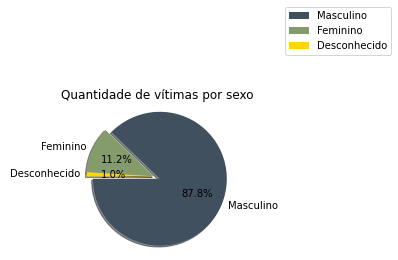

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
qtd = np.array([5023, 641, 56])
sexo = ['Masculino', 'Feminino', 'Desconhecido']

cores=['#40505f', '#849c6c', 'gold']
# O atributo explode indica que fatia do gráfico será destacada. 
# No exemplo abaixo, será a primeira fatia. 
#A quantidade de valores é igual ao número de fatias do gráfico. 
explode = (0.1, 0, 0,)  # explode 1st slice

# Atribuindo um título ao gráfico
plt.title('Quantidade de vítimas por sexo')

plt.pie(qtd, explode=explode, labels=sexo, colors=cores, 
        autopct='%1.1f%%', shadow=True, startangle=180)

#Adiciona Legenda
plt.legend(sexo, bbox_to_anchor=(1.3, 1.3),loc='lower right')

#Centraliza o gráfico
plt.axis('equal')

#Ajusta o espaçamento para evitar o recorte do rótulo
plt.tight_layout()

plt.show()

In [ ]:
ft = df_geral['faixa_etaria_vitima'] == '25-44'
ft1 = df_geral['cidade'] == 'São Paulo'

df_geral1 = df_geral.loc[ft & ft1]

In [ ]:
df_geral1.groupby(['distrito_zona']).size().sort_values(ascending=False)

distrito_zona
Zona Sul      572
Zona Leste    478
Zona Norte    354
Centro        102
Zona Oeste     93
dtype: int64